In [2]:
import os 
os.chdir("../..")

In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
# from src.utils.dataset import register_detectron2_multipart_datasets
import src.utils.dataset as uda
import src.utils.training as utr
from src.detection.rgb_ndvi_retinanet import RGB_NDVI_RetinaNet

SyntaxError: invalid syntax (<ipython-input-59-8a9781d407b8>, line 10)

In [5]:
!ls data/training/RGBN

lubsko		swiebodzin  torzym		       zagan
sulechow_slawa	szprotawa   train_val_test_splits.pkl


In [6]:
base_path = "data/training/RGBN/"
train_val_maps = ["szprotawa", "swiebodzin", "lubsko", "zagan", "torzym"]
test_maps = ["sulechow_slawa"]

In [7]:
splits = get_splits_for_multipart_dataset(base_path, train_val_maps, test_maps)

Reusing existing splits_file


In [8]:
register_detectron2_multipart_datasets("sick_trees", 
                                       {m: base_path + m for m in train_val_maps + test_maps},
                                       splits, min_bbox_area=200)

In [9]:
meta = MetadataCatalog.get('sick_trees_train')

In [10]:
%%time
train_dataset_dicts = DatasetCatalog.get("sick_trees_train")
len(train_dataset_dicts)

CPU times: user 12.4 s, sys: 10.4 ms, total: 12.4 s
Wall time: 12.4 s


22076

In [11]:
%%time
val_dataset_dicts = DatasetCatalog.get("sick_trees_val")
len(val_dataset_dicts)

CPU times: user 3.69 s, sys: 8.18 ms, total: 3.7 s
Wall time: 3.7 s


5497

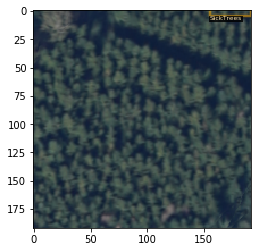

In [12]:
smpl = np.random.choice(val_dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=meta, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [13]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir tboard_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [14]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [15]:
from datetime import datetime

In [16]:
cfg = get_cfg()

# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"./tboard_logs/only_rgb_retinanet_augm_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("sick_trees_train",)
cfg.DATASETS.TEST = ("sick_trees_val",)

cfg.DATALOADER.NUM_WORKERS = 4

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"
cfg.INPUT.MIN_SIZE_TRAIN = (256,)
cfg.INPUT.MIN_SIZE_TEST = (256,)
cfg.INPUT.MAX_SIZE_TRAIN = (256,)
cfg.INPUT.MAX_SIZE_TEST = (256,)

cfg.MODEL.META_ARCHITECTURE = 'RetinaNet'
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = 1

# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = 2 # 32
cfg.SOLVER.BASE_LR = 0.001 # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 600_000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS = 10000
cfg.SOLVER.GAMMA = 0.3
cfg.SOLVER.STEPS = (100_000, 200_000, 300_000, 400_000, 500_000)

cfg.SOLVER.CHECKPOINT_PERIOD = 50_000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 10_000 # 5000 #200
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 100

Loading config /home/mkosturek/miniconda3/envs/geopython37/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [17]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [ ]:
# %%capture train_history
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = SickTreesAugmentedTrainer(cfg) 
# trainer.resume_or_load(resume=True)
trainer.resume_or_load(resume=False)
trainer.train()

[02/23 21:39:02 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

'head.cls_score.weight' has shape (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! Skipped.
'head.cls_score.bias' has shape (720,) in the checkpoint but (9,) in the model! Skipped.


[02/23 21:39:15 d2.engine.train_loop]: Starting training from iteration 0
[02/23 21:39:17 d2.utils.events]: eta: 9:30:04  iter: 19  total_loss: 1.617  loss_cls: 1.079  loss_box_reg: 0.558  time: 0.0581  data_time: 0.0094  lr: 0.000003  max_mem: 557M
[02/23 21:39:18 d2.utils.events]: eta: 9:26:38  iter: 39  total_loss: 1.556  loss_cls: 1.068  loss_box_reg: 0.491  time: 0.0573  data_time: 0.0057  lr: 0.000005  max_mem: 557M
[02/23 21:39:19 d2.utils.events]: eta: 9:26:09  iter: 59  total_loss: 1.490  loss_cls: 1.055  loss_box_reg: 0.460  time: 0.0571  data_time: 0.0056  lr: 0.000007  max_mem: 557M
[02/23 21:39:20 d2.utils.events]: eta: 9:25:52  iter: 79  total_loss: 1.446  loss_cls: 1.027  loss_box_reg: 0.426  time: 0.0569  data_time: 0.0053  lr: 0.000009  max_mem: 557M
[02/23 21:39:22 d2.utils.events]: eta: 9:26:05  iter: 99  total_loss: 1.416  loss_cls: 0.995  loss_box_reg: 0.428  time: 0.0568  data_time: 0.0054  lr: 0.000011  max_mem: 557M
[02/23 21:39:23 d2.utils.events]: eta: 9:26:07

In [19]:
1+2

3

In [20]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("sick_trees_test", )
# cfg.TEST.SCORE_THRESHOLD = 0.3
# cfg.TEST.SCORE_THRESH_TEST = 0.3
# cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3


cfg.TEST.DETECTIONS_PER_IMAGE = 10
predictor = DefaultPredictor(cfg)

predictor.cfg["TEST"]

CfgNode({'EXPECTED_RESULTS': [], 'EVAL_PERIOD': 3000, 'KEYPOINT_OKS_SIGMAS': [], 'DETECTIONS_PER_IMAGE': 10, 'AUG': CfgNode({'ENABLED': False, 'MIN_SIZES': (400, 500, 600, 700, 800, 900, 1000, 1100, 1200), 'MAX_SIZE': 4000, 'FLIP': True}), 'PRECISE_BN': CfgNode({'ENABLED': False, 'NUM_ITER': 200})})

In [40]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("sick_trees_val", )
# cfg.TEST.SCORE_THRESHOLD = 0.3
# cfg.TEST.SCORE_THRESH_TEST = 0.3
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3


cfg.TEST.DETECTIONS_PER_IMAGE = 10
predictor = DefaultPredictor(cfg)

predictor.cfg["TEST"]

CfgNode({'EXPECTED_RESULTS': [], 'EVAL_PERIOD': 3000, 'KEYPOINT_OKS_SIGMAS': [], 'DETECTIONS_PER_IMAGE': 10, 'AUG': CfgNode({'ENABLED': False, 'MIN_SIZES': (400, 500, 600, 700, 800, 900, 1000, 1100, 1200), 'MAX_SIZE': 4000, 'FLIP': True}), 'PRECISE_BN': CfgNode({'ENABLED': False, 'NUM_ITER': 200})})

In [24]:
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [43]:
torch.as_tensor([im.transpose(2,0,1)]).shape

torch.Size([1, 3, 256, 256])

In [46]:
from src.utils.training import DatasetMapper

In [52]:
mapper = DatasetMapper(cfg, False)

In [54]:
predictor.model([mapper(d)])

[{'instances': Instances(num_instances=0, image_height=256, image_width=256, fields=[pred_boxes = Boxes(tensor([], device='cuda:0', size=(0, 4))), scores = tensor([], device='cuda:0', grad_fn=<IndexBackward>), pred_classes = tensor([], device='cuda:0', dtype=torch.int64), ])}]

In [28]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("sick_trees_val")

In [33]:
im.shape

(256, 256, 3)

In [ ]:
smpl = np.random.choice(val_dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=meta, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [49]:
mapper = SickTreesDatasetMapper(cfg, False, 3)

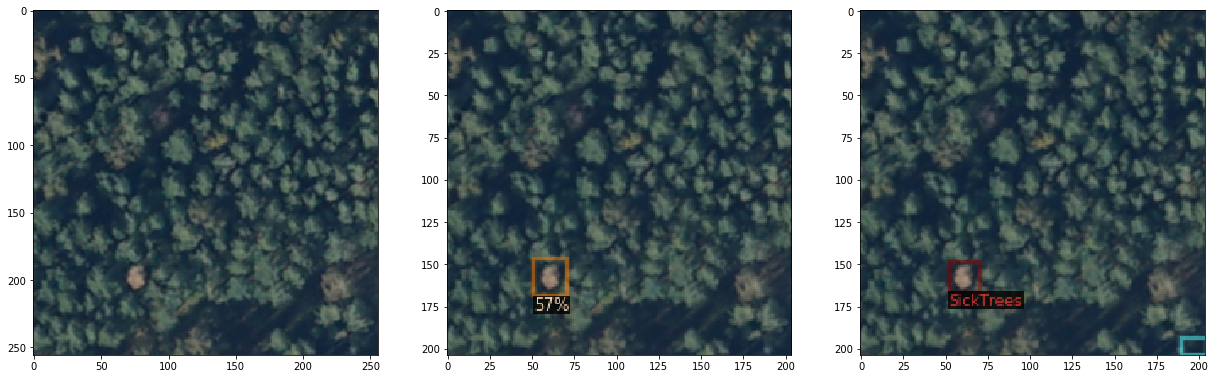

In [58]:
import time
import torch
for d in np.random.choice(val_dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
#     outputs = predictor(im)
    with torch.no_grad():
        outputs = predictor.model([mapper(d)])[0]
#         outputs = predictor.model(im[:,:,:3:-1])
    v = Visualizer(im[:,:,::1].copy(),
                   metadata=meta, 
                   scale=0.8)
    
    vis = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    f, a = plt.subplots(1,3, figsize=(21,7))
    a[0].imshow(im[:,:,::1])
    a[1].imshow(vis.get_image())
    
    v = Visualizer(im[:,:,::1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_dataset_dict(d)
    a[2].imshow(vis.get_image())

In [54]:
_ = register_detectron2_datasets("szprott", "./data/szprotawa_patches_256/", 0.7, 0.15, 0.15, 100, {'test': splits['test'][:500]})

TypeError: register_detectron2_datasets() takes from 3 to 5 positional arguments but 7 were given

In [23]:
from detectron2.evaluation import DatasetEvaluator, COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader



evaluator = COCOEvaluator("sick_trees_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
# val_loader = build_detection_test_loader(cfg, "sick_trees_val")
val_loader = trainer.build_test_loader(cfg, "sick_trees_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[02/24 16:45:55 d2.evaluation.evaluator]: Start inference on 5497 images
[02/24 16:45:55 d2.evaluation.evaluator]: Inference done 11/5497. 0.0205 s / img. ETA=0:01:57
[02/24 16:46:00 d2.evaluation.evaluator]: Inference done 244/5497. 0.0202 s / img. ETA=0:01:52
[02/24 16:46:05 d2.evaluation.evaluator]: Inference done 477/5497. 0.0202 s / img. ETA=0:01:47
[02/24 16:46:10 d2.evaluation.evaluator]: Inference done 709/5497. 0.0202 s / img. ETA=0:01:43
[02/24 16:46:15 d2.evaluation.evaluator]: Inference done 934/5497. 0.0204 s / img. ETA=0:01:38
[02/24 16:46:20 d2.evaluation.evaluator]: Inference done 1156/5497. 0.0205 s / img. ETA=0:01:34
[02/24 16:46:25 d2.evaluation.evaluator]: Inference done 1380/5497. 0.0206 s / img. ETA=0:01:30
[02/24 16:46:30 d2.evaluation.evaluator]: Inference done 1609/5497. 0.0206 s / img. ETA=0:01:25
[02/24 16:46:35 d2.evaluation.evaluator]: Inference done 1830/5497. 0.0207 s / img. ETA=0:01:20
[02/24 16:46:40 d2.evaluation.evaluator]: Inference done 2051/5497. 0

OrderedDict([('bbox',
              {'AP': 26.922909756245065,
               'AP50': 72.70625644388706,
               'AP75': 12.007141341298473,
               'APs': 21.580032941254093,
               'APm': 31.08286308575438,
               'APl': 39.09241007531098})])

In [38]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.WEIGHTS = os.path.join("tboard_logs/retinanet_test_2020-02-21T00:24/", "model_final.pth")


# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("sick_trees_val", )
# cfg.TEST.SCORE_THRESHOLD = 0.3
# cfg.TEST.SCORE_THRESH_TEST = 0.3
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3


cfg.TEST.DETECTIONS_PER_IMAGE = 10
predictor = DefaultPredictor(cfg)

predictor.cfg["TEST"]

CfgNode({'EXPECTED_RESULTS': [], 'EVAL_PERIOD': 3000, 'KEYPOINT_OKS_SIGMAS': [], 'DETECTIONS_PER_IMAGE': 10, 'AUG': CfgNode({'ENABLED': False, 'MIN_SIZES': (400, 500, 600, 700, 800, 900, 1000, 1100, 1200), 'MAX_SIZE': 4000, 'FLIP': True}), 'PRECISE_BN': CfgNode({'ENABLED': False, 'NUM_ITER': 200})})

In [39]:
from detectron2.evaluation import DatasetEvaluator, COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader



evaluator = COCOEvaluator("test_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
# val_loader = build_detection_test_loader(cfg, "sick_trees_val")
val_loader = trainer.build_test_loader(cfg, "test_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[02/24 17:22:20 d2.evaluation.evaluator]: Start inference on 11845 images
[02/24 17:22:21 d2.evaluation.evaluator]: Inference done 11/11845. 0.0217 s / img. ETA=0:04:25
[02/24 17:22:26 d2.evaluation.evaluator]: Inference done 237/11845. 0.0209 s / img. ETA=0:04:17
[02/24 17:22:31 d2.evaluation.evaluator]: Inference done 466/11845. 0.0208 s / img. ETA=0:04:10
[02/24 17:22:36 d2.evaluation.evaluator]: Inference done 695/11845. 0.0207 s / img. ETA=0:04:05
[02/24 17:22:41 d2.evaluation.evaluator]: Inference done 924/11845. 0.0207 s / img. ETA=0:04:00
[02/24 17:22:46 d2.evaluation.evaluator]: Inference done 1155/11845. 0.0207 s / img. ETA=0:03:54
[02/24 17:22:51 d2.evaluation.evaluator]: Inference done 1357/11845. 0.0211 s / img. ETA=0:03:54
[02/24 17:22:56 d2.evaluation.evaluator]: Inference done 1589/11845. 0.0210 s / img. ETA=0:03:48
[02/24 17:23:01 d2.evaluation.evaluator]: Inference done 1821/11845. 0.0209 s / img. ETA=0:03:42
[02/24 17:23:06 d2.evaluation.evaluator]: Inference done 20

OrderedDict([('bbox',
              {'AP': 19.428527554244397,
               'AP50': 57.34887274576243,
               'AP75': 6.655671917103967,
               'APs': 19.57672532687265,
               'APm': 20.362407285113747,
               'APl': 22.43435824936349})])

In [24]:
import pandas as pd

In [26]:
df = pd.read_pickle("./data/training/RGBN/sulechow_slawa/annotation.pkl")

In [28]:
splits['train'] = df["patch_number"].unique()

NameError: name 'splist' is not defined

In [29]:
splits['test']

{'szprotawa': [],
 'swiebodzin': [],
 'lubsko': [],
 'zagan': [],
 'torzym': [],
 'sulechow_slawa': array([   138,    139,    140, ..., 156406, 156407, 156408])}

In [30]:
DatasetCatalog.get('sick_trees_test')

[]

In [36]:
register_detectron2_multipart_datasets("test", 
                                       {m: base_path + m for m in test_maps},
                                       splits, min_bbox_area=200)
